# Retrieval Augmented Generation

<font color='purple'>**Retrieval Augmented Generation (RAG)**</font> is a powerful paradigm in natural language processing that combines the strengths of information retrieval and language generation. In the context of the **OpenAI API**, this approach involves retrieving relevant information from a large dataset and using that information to enhance the generation of accurate text. It can be used as another method to fine-tune your models. 

The phrase <font color='purple'>**Retrieval Augmented Generation**</font> comes from a recent paper by Lewis et al. from Facebook AI (https://research.facebook.com/publications/retrieval-augmented-generation-for-knowledge-intensive-nlp-tasks/). The idea is to use a pre-trained language model (LM) to generate text, but to use a separate retrieval system to find relevant documents to condition the LM on.

### _How it Works_

From start to finish, the RAG relies on 5 steps:

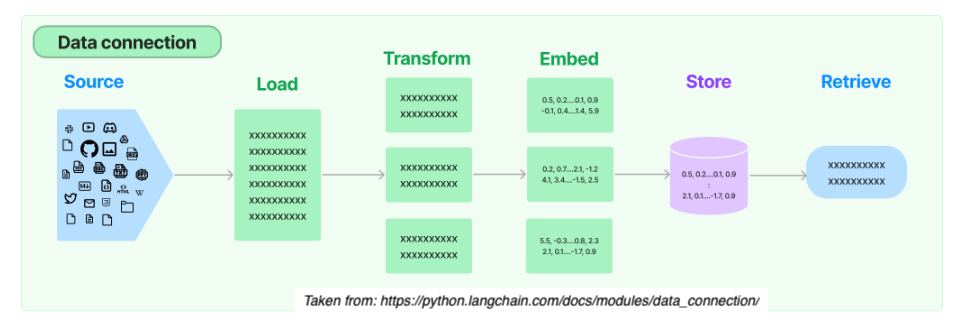

In [8]:
from IPython.display import Image
Image(filename='rag.png')

&nbsp; 1\.) **Load**:

> Load documents from different source files (urls, csvs, pdfs, text) in diverse locations (s3 storage, public sites, etc.)

&nbsp; 2\.) **Transform**

> Retrieval also involves determining the relevant parts of documents. To prepare larger document for retrieval it is often necessary to split or chunk the data.

&nbsp; 3.) **Embed**

> Next embeddings must be created for documents to capture the semantic meaning of the text. This later enables mdoels to efficiently find other pieces of text that are similar.

&nbsp; 4.) **Store**

> Vector stores support efficient storage and search of document embeddings. 

&nbsp; 5.) **Retrive**

> One the data is organized, the relevant information is retrieved to produce more informed and context-aware responses.

This blending of retrieval and generation enhances the richness and relevance of the generated content.


### _Sample Uses Cases_

- **Question Answering Systems**: Question answering systems retrieve information from vast knowledge bases, such as multiple pdfs or csv files.

- **Content Creation**: In content creation applications, RAG can enhance the generation of creative and informative text by pulling in relevant details from a wide range of sources.

- **Conversational Agents**: Chatbots and conversational agents benefit from RAG by incorporating external knowledge into responses

- **Code Generation**: RAG can assist in generating code snippets by retrieving information from programming knowledge bases. (example today)

- **Prevent Hallucinations**: RAG can be used to bring in external knowledge to check whether a GPT response is a hallucination. (example provided)

### _Getting Started_

Please install and import these libraries.

In [2]:
# primary libraries to import
import openai
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain import OpenAI
from langchain.chains import VectorDBQAWithSourcesChain
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema import StrOutputParser


# also need
import requests
import faiss
import pickle
import numpy as np
import os


Remember to set your API key.

In [3]:
from dotenv import load_dotenv # pip install python-dotenv

# load the .env file containing your API key
load_dotenv()

True

### _Example A: Retrieving Updated Selenium Syntax_

One way to use RAG is to feed it an external knowledge source to help improve your code. Over the summer, the Python Selenium library was upgraded from version 3 to version 4. Let's ask GPT a question about how to find a class element using Python Selenium.  

In [4]:
# Ask GPT-3 about the Python version
prompt = "How do I find an element by class name in the latest version of python selenium?"

# Generate response using GPT-3
client = openai.OpenAI()

response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106",
    messages=[
        {
        "role": "system",
        "content": "You are a helfpul assistant."
        },
        {
        "role": "user",
        "content": prompt
        }
    ],
)

# Display the generated text
generated_text = response.choices[0].message.content
print(f"Answer: {generated_text}")

Answer: In the latest version of Python Selenium, you can find an element by class name using the `find_element_by_class_name` method. Here's an example of how to use it:

```python
from selenium import webdriver

# Start a new web browser session
driver = webdriver.Chrome()

# Open the website
driver.get('https://www.example.com')

# Find the element by class name
element = driver.find_element_by_class_name('yourClassName')

# Do something with the element, for example, get its text
print(element.text)

# Close the web browser session
driver.quit()
```

Replace `'yourClassName'` with the actual class name of the element you're looking for.


This code for finding elements by class name no longer works in newer versions of selenium found here: https://www.selenium.dev/documentation/webdriver/troubleshooting/upgrade_to_selenium_4/

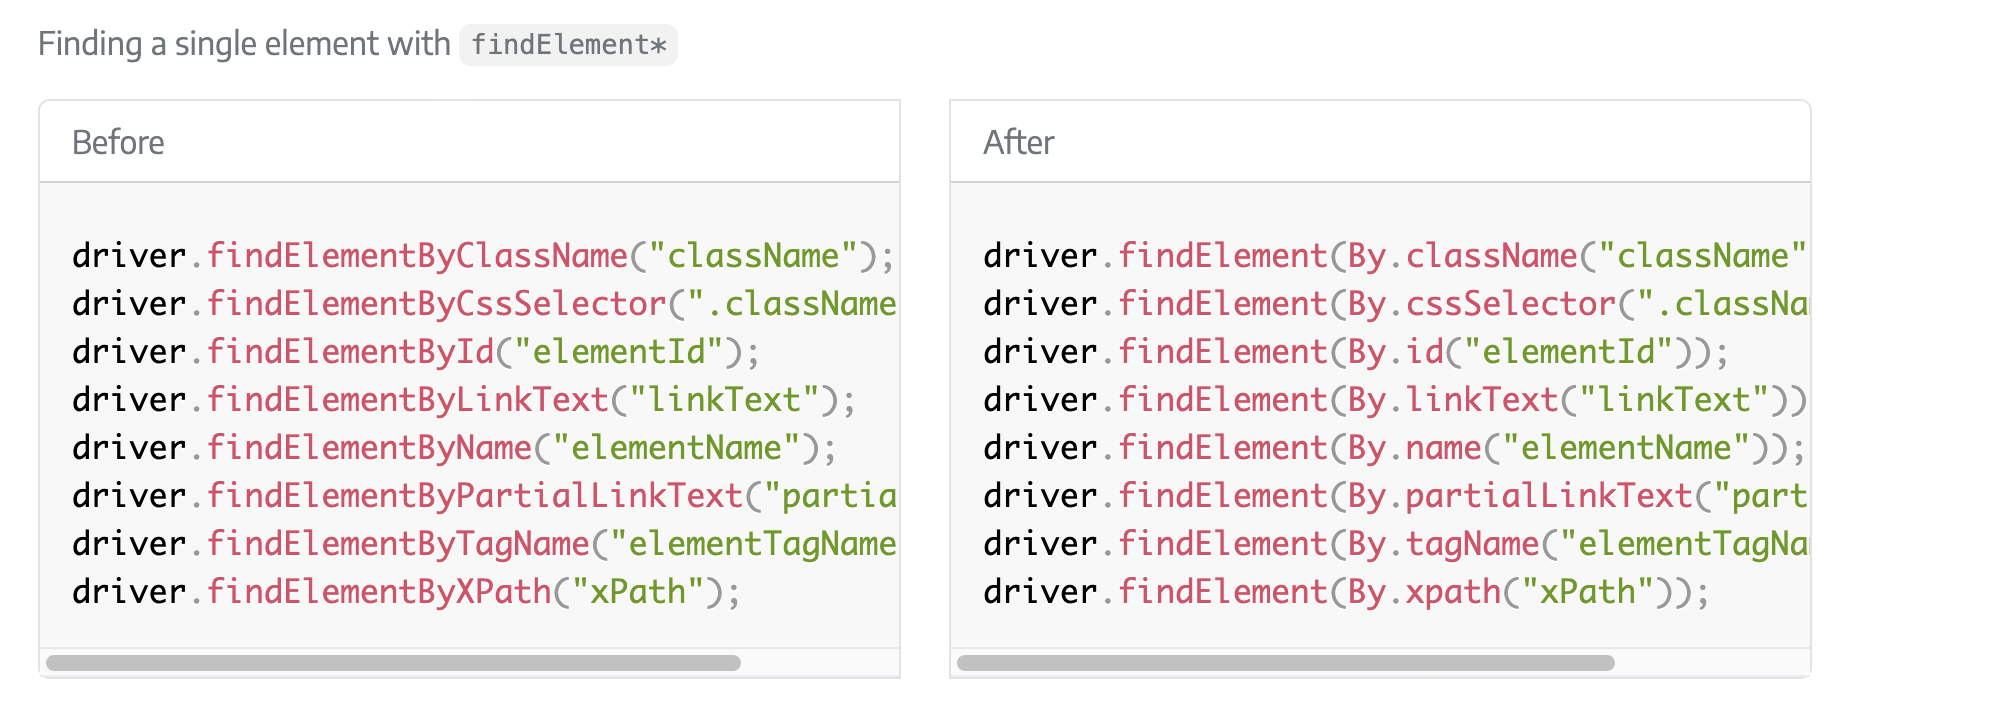

In [6]:
from IPython.display import Image
Image(filename='selenium.png')

To resolve this, we can use RAG to feed GPT details on the newest version of Selenium. The code below will take the contents of a webpage and follow the 5 steps outlined above to retrieve the relevant information about selenium.

<font color='blue'>_Note that the RAG code was summarized from this post: https://www.shruggingface.com/blog/langchain-cloudflare-qa-agent.  Please see the original post for additional details._</font>

In [7]:
# 1.) Load
url = "https://www.selenium.dev/documentation/webdriver/troubleshooting/upgrade_to_selenium_4/"
response = requests.get(url)
webpage_content = response.text 

# 2.) Transform - Split the content into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=1500, separator="\n")
chunks = text_splitter.split_text(webpage_content)

# 3.) Embed
embeddings = OpenAIEmbeddings(openai_api_key=os.getenv('OPENAI_API_KEY'))
metadata = [{"source": url} for _ in range(len(chunks))]  # Metadata for each chunk

# 4.) Store
store = FAISS.from_texts(chunks, embeddings, metadatas=metadata)

# 5.) Retrieve

# Build the question answering chain
chain = VectorDBQAWithSourcesChain.from_llm(
    llm=OpenAI(openai_api_key=os.getenv('OPENAI_API_KEY'), 
               temperature=0, max_tokens=1500, 
               model_name='text-davinci-003'), 
               vectorstore=store
)

# Ask GPT a question
question = "How do I find an element by class name in the latest version of python selenium? Show an example."
result = chain({"question": question})

# Print the answer.
print(f"Answer: {result['answer']}")


Created a chunk of size 4540, which is longer than the specified 1500
Created a chunk of size 1584, which is longer than the specified 1500
Created a chunk of size 52413, which is longer than the specified 1500
Created a chunk of size 1920, which is longer than the specified 1500
Created a chunk of size 3412, which is longer than the specified 1500
Created a chunk of size 3707, which is longer than the specified 1500
/Users/ambreenchaudhri/anaconda3/envs/rag/lib/python3.11/site-packages/langchain/chains/qa_with_sources/vector_db.py:65: UserWarning: `VectorDBQAWithSourcesChain` is deprecated - please use `from langchain.chains import RetrievalQAWithSourcesChain`
  warnings.warn(


Answer:  In the latest version of python selenium, you can find an element by class name using the following methods: driver.findElement(By.className("className")); driver.findElement(By.cssSelector(".className")); driver.findElementsByCssSelector(".className");



### _Example B: Preventing Hallucinations_

Another advantage of using RAG is to feed GPT an external knowledge source to check or prevent hallucinations. An <font color='purple'>**artificial hallucination**</font> is a response that contains false or misleading information presented as factual. This could be something as innocuous as saying an item exists in a file that doesn't. Conversely, it could be an instance when GPT actually provides false information. Here is an example of Ellie, the elephant that walked on the moon. 

```python
prompt = "Can you tell me more about the first elephant that landed on the moon?"

# Generate response using GPT-3
response = openai.Completion.create(
    engine="text-davinci-002",  
    prompt=prompt,
    max_tokens=100,  
    temperature=0.0, 
)

# Display the generated text
generated_text = response["choices"][0]["text"]
print(f"Answer: {generated_text}")
```

Answer: 

The first elephant to land on the moon was a female elephant named Ellie. She was born in captivity in Africa and was brought to the United States when she was two years old. Ellie spent the majority of her life performing in circuses and zoos. In 1962, she was sent to the National Zoo in Washington, D.C. where she lived for the rest of her life. Ellie died in 1988 at the age of 36.

Just note that the newest version of the GPT model will not produce this same hallucination. 

In [4]:
# Ask GPT-3 about the Python version
prompt = "Can you tell me more about the first elephant that landed on the moon?"

# Generate response using GPT-3
client = openai.OpenAI()

response = client.chat.completions.create(
    model="gpt-4-0613",
    messages=[
        {
        "role": "system",
        "content": "You are a helfpul assistant."
        },
        {
        "role": "user",
        "content": prompt
        }
    ],
)

# Display the generated text
generated_text = response.choices[0].message.content
print(f"Answer: {generated_text}")


Answer: I'm sorry for any confusion, but there actually hasn't been an elephant that has landed on the moon. The only living creatures to have made the journey to the moon are a select group of astronauts during the Apollo missions of the 1960s and 1970s conducted by NASA. One of the most noted being Neil Armstrong, the first man to walk on the moon during the Apollo 11 mission in 1969.


In order to check or correct this hallucination, we can use RAG to upload a text file to GPT.

In [14]:
# data
data = "There has never been an elephant on the moon."

# embed and store
vectorstore = FAISS.from_texts(
    [data], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()


In [15]:
# Retrieval
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("Can you tell me about the first elephant on the moon?")

'Based on the given context, there has never been an elephant on the moon.'